## Install Tabnet Package and Import Tabnet Model:

In [1]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl



In [2]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

**Import Important Libraries:**

In [3]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [4]:
labels = ['None', 'Mild', 'Moderate', 'Severe']

## Preprocessing Data:

### Discrete Data Analysis:

Read dataset

In [5]:
train = pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

display(train)
display(test)

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,null,null,nul

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,str,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


As can be seen in file ***data_dictionary.csv***, all the Season-related columns are **string** type. Since we have 4 seasons only, we wanna convert it into **categorical** data (***enum***).

In [6]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

In [7]:
train = train.with_columns(pl.col('^.*Season$').cast(season_dtype))
test = test.with_columns(pl.col('^.*Season$').cast(season_dtype))

display(train)
display(test)

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,nu

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


We see that at most columns (especially the target label columns ***ssi***), there are many missing values. , Since this is a supervised-learning problem, we have to:

* Accept removing data samples where label ***ssi*** is not available(*null*).
* From our new dataset(validlabel_dataset) containing only rows where sii is available, we **count** the missing values of each other feature and plot them.

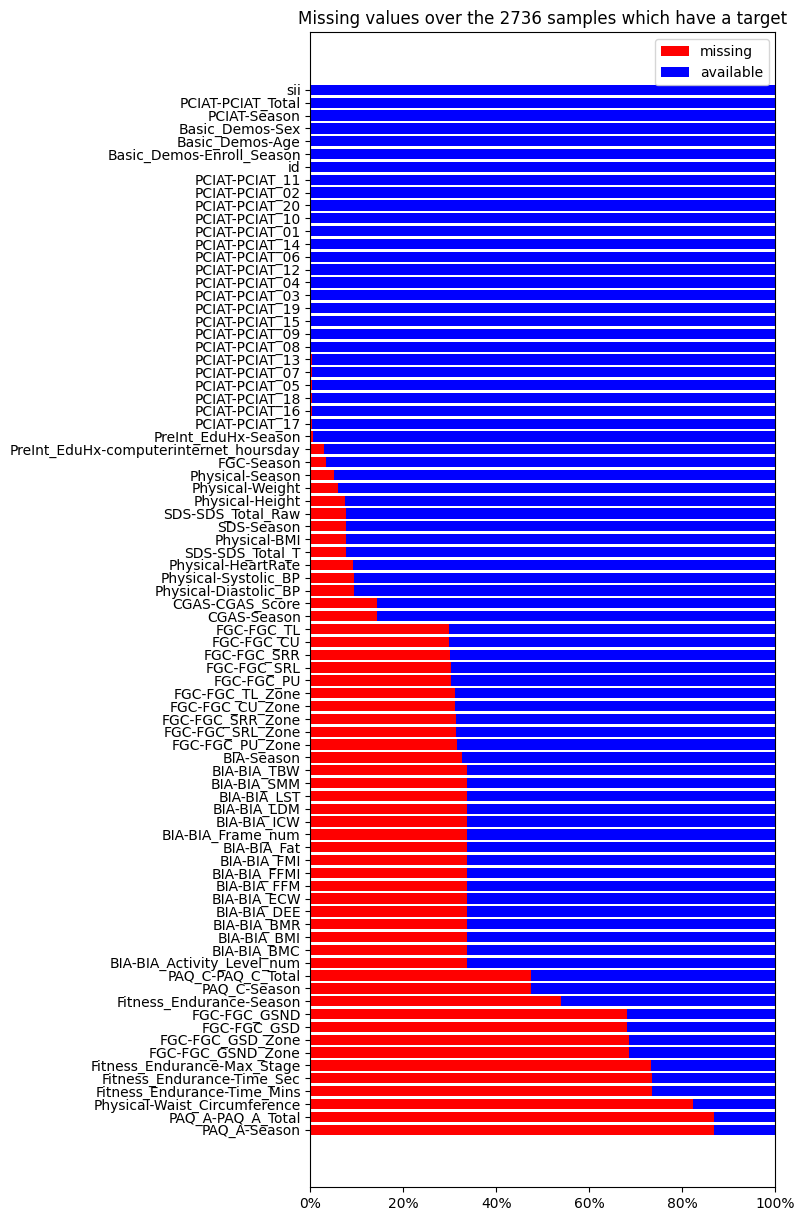

In [8]:
validlabel_dataset = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    validlabel_dataset
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(validlabel_dataset)).alias('null_ratio'))
)

# Visualize missing data
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(validlabel_dataset)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='red', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='blue', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

As can be seen from the labels, half of the samples are in class 0, while very few in class 3.

=> We can infer the dataset seems imbalanced.

<Axes: xlabel='sii'>

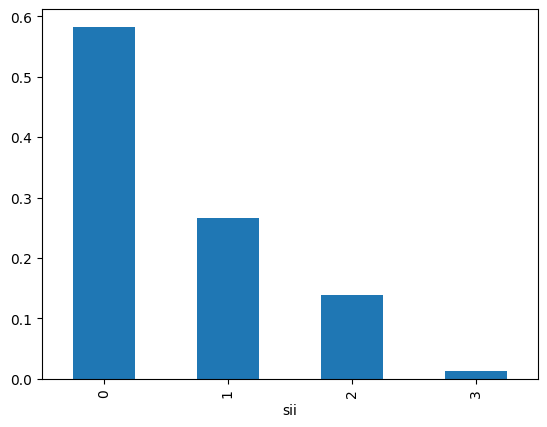

In [9]:
# Convert to Pandas for plotting
value_counts_pd = validlabel_dataset.to_pandas()

# Plot the bar chart
value_counts_pd['sii'].value_counts(normalize=True).plot(kind='bar')

There are also missing values in test dataset

In [10]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


#### Univariate Analysis

Here, we plot and visualize some features. Remember that we have 2 main features dtype, which are categorical type(categorical int and enum) and numeric type (int and float).

**1. Categorical Features:**

- Raw Train Dataset:

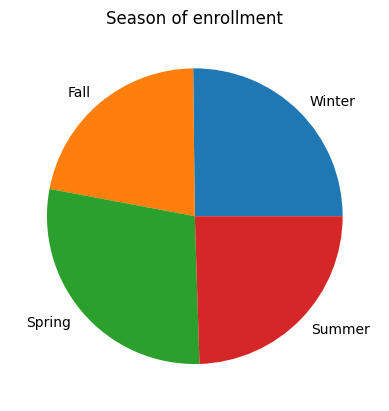

In [11]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

- validlabel_dataset:

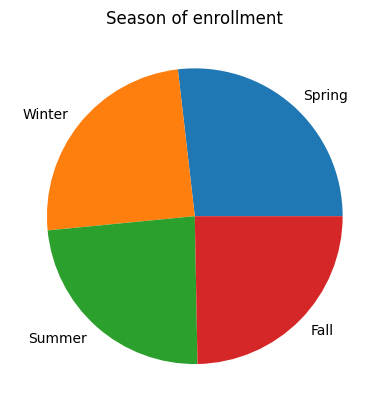

In [12]:
vc = validlabel_dataset.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

- Raw Train Dataset:

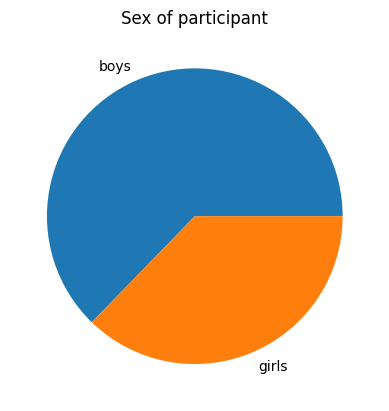

In [13]:
vc = train.get_column('Basic_Demos-Sex').value_counts()
plt.pie(vc.get_column('count'), labels=['boys', 'girls'])
plt.title('Sex of participant')
plt.show()

- validlabel_dataset:

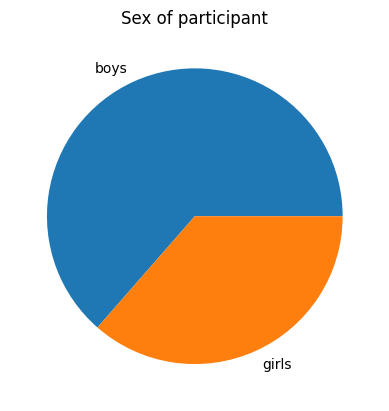

In [14]:
vc = validlabel_dataset.get_column('Basic_Demos-Sex').value_counts()
plt.pie(vc.get_column('count'), labels=['boys', 'girls'])
plt.title('Sex of participant')
plt.show()

**2.  Numeric Features:**

- Raw Train Dataset:

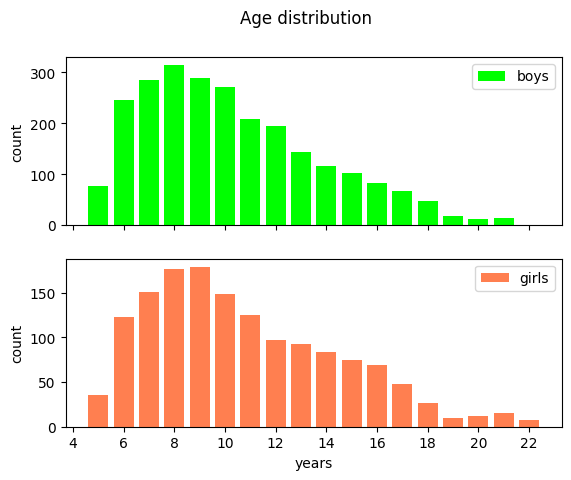

In [15]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lime', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()


- validlabel_dataset:

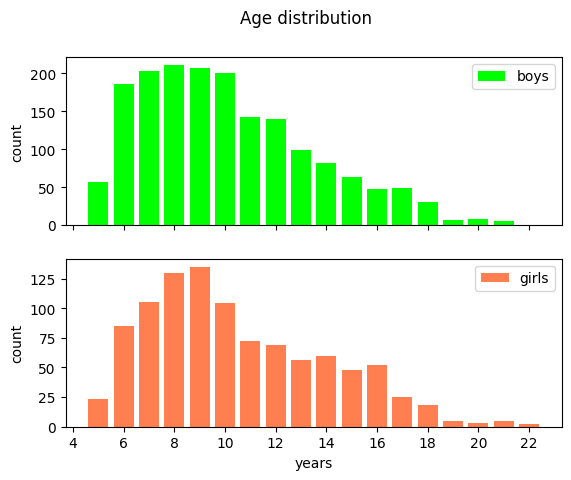

In [16]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = validlabel_dataset.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lime', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()


#### Bivariate Analysis:

- Correlation Matrix:

* Starting from fundamental belief that each Feature contributes to deciding the final ouput result(label 'sii'). Hence, they might have some Relationship with the label, we call this 'Correlation'. Moreover, this 'Correlation' might exist among features.
* Here, we estimate the Correlation Matrix which calculates the relation among features, and keep the correlation between each single feature and target feature (PCIAT-PCIAT_Total), because this feature decides the ssi values. 

<Figure size 1400x1200 with 0 Axes>

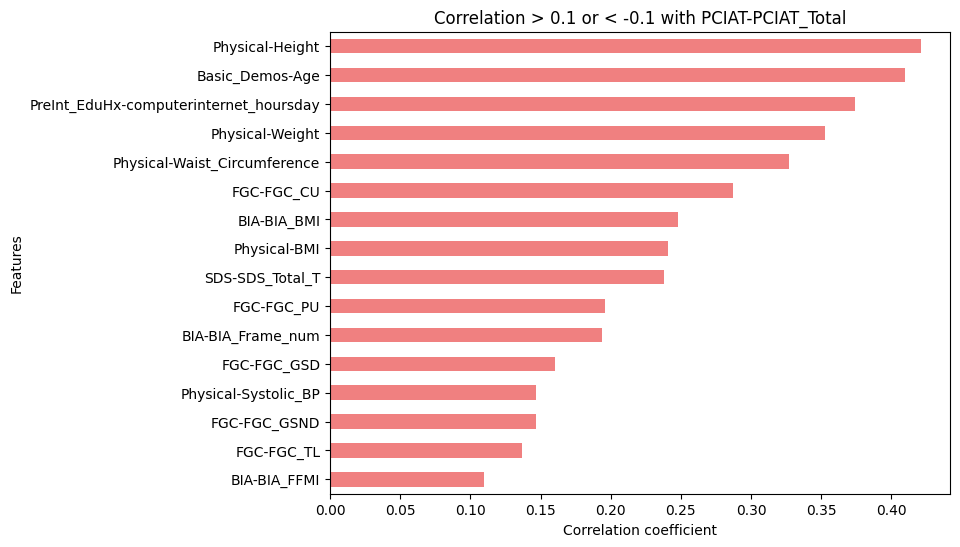

In [17]:
plt.figure(figsize=(14, 12))
# Correlation Matrix
corr_matrix = validlabel_dataset.select([
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
    # Add other relevant columns
]).to_pandas().corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total') # Drop correlation between PCIAT-PCIAT_Total and PCIAT-PCIAT_Total
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

#Plot the correlation matrix
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='lightcoral')
plt.title('Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

### Continuous Data Analysis ( Time Series):

We analyze and visualize actigraphy data for a specific individual identified by their id. Actigraphy data, typically collected from wearable devices, measures movement (via acceleration) and other related metrics (e.g., light exposure). The aim is to inspect and understand behavioral patterns over time by examining specific features, with options to focus on a single week or simplify the analysis.

1. Understand Behavioral Patterns:
* By plotting metrics like acceleration (X, Y, Z), light exposure, and derived measures (norm, enmo), we gain insights into daily activity trends.
* The function filters and highlights relevant data, such as periods when the wearable device was actively used.

2. Inspect Subsets of Data:

Allows filtering the data to focus on a smaller subset, such as one week's worth of activity.
Can visualize specific features to simplify or tailor analysis for specific use cases.

3. Support Data Cleaning:

By visualizing metrics like non-wear_flag, analysts can ensure that unwanted or invalid data points are excluded from further analysis.

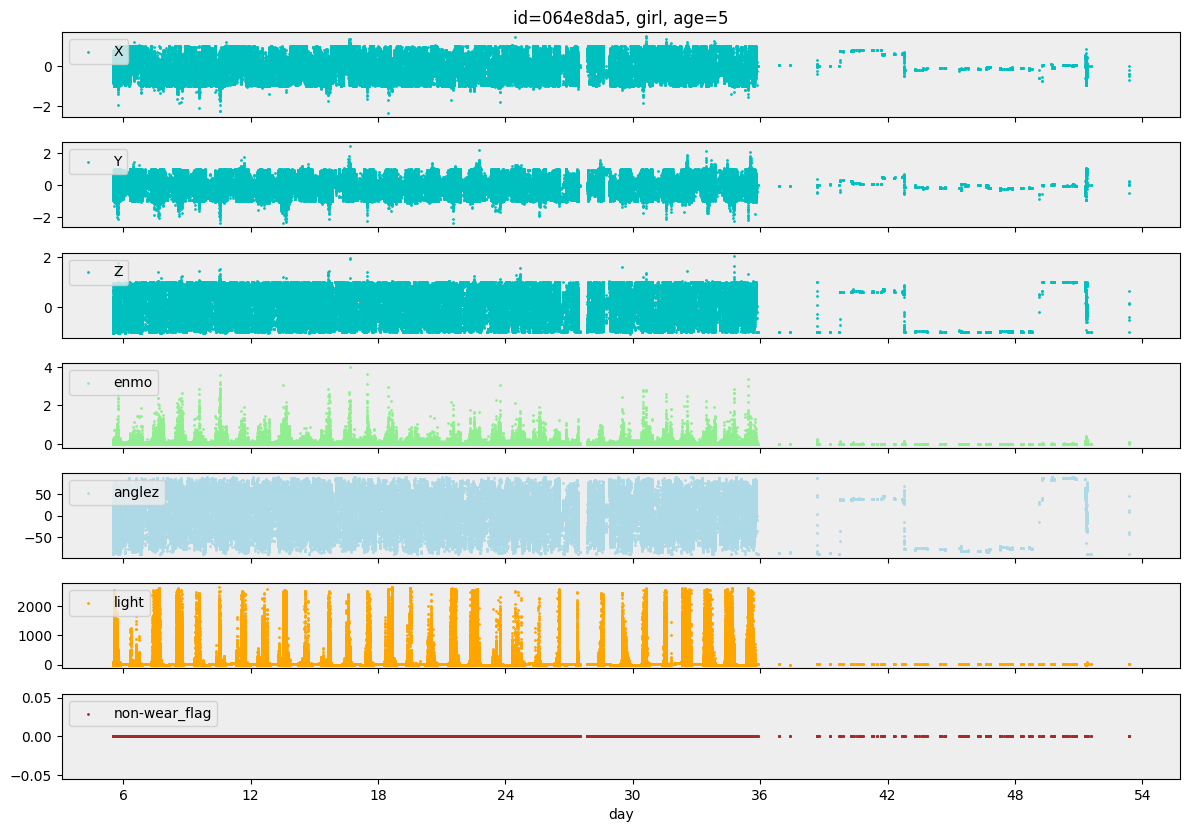

In [18]:
def analyze_actigraphy(actigraphy='/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet', id=0, only_one_week=False, small=False):

    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'c'),
            ('Y', 'c'),
            ('Z', 'c'),
#             ('norm', 'c'),
            ('enmo', 'lightgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'brown')
    #         ('diff_seconds', 'k'),
        ]

    # Plotting
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()
    

# Import And Read Time Series Dataset
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
# display(actigraphy)
analyze_actigraphy(actigraphy,'064e8da5', only_one_week=False)

## Feature Engineering

* Processes all files in a directory using multithreading (ThreadPoolExecutor and tqdm for progress tracking).
* Returns a DataFrame with summary statistics for each file.


In [19]:
def process_file(filename, dirname):
    dataset = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    dataset.drop('step', axis=1, inplace=True)
    return dataset.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    dataset = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    dataset['id'] = indexes
    return dataset

This below Encoder Class Learns representation of each feature, the relationship among them.
* The Encoder learns relation of features (including the missing ones).
* The Decoder retrieves the original data (return the full dataset, and it will label the null values). 

At the end, we have a so-called 'pretrained' model (The Encoder)

> *Note: We must **NOT** call the Decoder. It is just for testing if dataset is restored as origin or not*

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def Encoding(dataset, encoding_dim=50, epochs=50, batch_size=32):
    # Standardalize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataset)
    
    data_tensor = torch.FloatTensor(df_scaled)

    # Setup Encoder
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss() # Loss Function
    optimizer = optim.Adam(autoencoder.parameters()) # Optimizer

    # 'Training' to extract features representations
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    # After having the Encoder learnt parameters and feature representations, call Encoder to train the real model
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

* Read our dataset:

In [21]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

train_id = train_ts.drop('id', axis=1)
test_id = test_ts.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


* Train AutoEncoder for **time series** dataset:

In [22]:
train_ts_encoded = Encoding(train_id, encoding_dim=60, epochs=100, batch_size=32) # Output will be 60 columns(features)
test_ts_encoded = Encoding(test_id, encoding_dim=60, epochs=100, batch_size=32)# Output will be 60 columns(features)

Epoch [10/100], Loss: 1.5758]
Epoch [20/100], Loss: 1.5225]
Epoch [30/100], Loss: 1.5015]
Epoch [40/100], Loss: 1.4869]
Epoch [50/100], Loss: 1.4612]
Epoch [60/100], Loss: 1.4617]
Epoch [70/100], Loss: 1.4357]
Epoch [80/100], Loss: 1.4344]
Epoch [90/100], Loss: 1.4320]
Epoch [100/100], Loss: 1.3966]
Epoch [10/100], Loss: 0.9966]
Epoch [20/100], Loss: 0.5646]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


In [23]:
time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

# Merge time series encoded with train and test
train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

# imputer: Fill in the Missing values in numeric columns using a KNNImputer.
# For each missing value,looks at the 5 nearest rows and computes the mean of the corresponding values to replace the missing value.
# Remember if it cannot find missing values based on 5 nearest neighbors, its value is set to inf
imputer = KNNImputer(n_neighbors=6)
numeric_cols = train.select_dtypes(include=['int32', 'int64', 'float64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

# Assign the numeric columns with no missing values into train (mean train loses categorical columns)
# Note: We'll have to add categorical columns later
train = train_imputed

* Next step is Feature Engineering. We will create new columns from 2 old columns. These new columns will have features of both, plus its own information (hidden features). That way, our can learn and give better performance.

In [24]:
def feature_engineering(data):
    season_cols = [col for col in data.columns if 'Season' in col]
    data = data.drop(season_cols, axis=1) 
    data['BMI_Age'] = data['Physical-BMI'] * data['Basic_Demos-Age']
    data['Internet_Hours_Age'] = data['PreInt_EduHx-computerinternet_hoursday'] * data['Basic_Demos-Age']
    data['BMI_Internet_Hours'] = data['Physical-BMI'] * data['PreInt_EduHx-computerinternet_hoursday']
    data['BFP_BMI'] = data['BIA-BIA_Fat'] / data['BIA-BIA_BMI']
    data['FFMI_BFP'] = data['BIA-BIA_FFMI'] / data['BIA-BIA_Fat']
    data['FMI_BFP'] = data['BIA-BIA_FMI'] / data['BIA-BIA_Fat']
    data['LST_TBW'] = data['BIA-BIA_LST'] / data['BIA-BIA_TBW']
    data['BFP_BMR'] = data['BIA-BIA_Fat'] * data['BIA-BIA_BMR']
    data['BFP_DEE'] = data['BIA-BIA_Fat'] * data['BIA-BIA_DEE']
    data['BMR_Weight'] = data['BIA-BIA_BMR'] / data['Physical-Weight']
    data['DEE_Weight'] = data['BIA-BIA_DEE'] / data['Physical-Weight']
    data['SMM_Height'] = data['BIA-BIA_SMM'] / data['Physical-Height']
    data['Muscle_to_Fat'] = data['BIA-BIA_SMM'] / data['BIA-BIA_FMI']
    data['Hydration_Status'] = data['BIA-BIA_TBW'] / data['Physical-Weight']
    data['ICW_TBW'] = data['BIA-BIA_ICW'] / data['BIA-BIA_TBW']
    data['BMI_PHR'] = data['Physical-BMI'] * data['Physical-HeartRate']
    data['SDS_InternetHours'] = data['SDS-SDS_Total_T'] * data['PreInt_EduHx-computerinternet_hoursday']
    
    return data

In [25]:
train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

train = train.drop('id', axis=1)
test  = test .drop('id', axis=1)   

* Next, we add missing columns(categorical columns) except for 'sii'

In [26]:
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR', 'SDS_InternetHours']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')


featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR', 'SDS_InternetHours']

featuresCols += time_series_cols
test = test[featuresCols]

* Since there is inf values in our dataset, we need to handle them:

In [27]:
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

## Models Build

Here, we use below models. These models all have strong multi-classfication, which are widely used.
* **LightXGBM**.* **XGBoost**.
* **CatBoost**.
* **Voting Regressor**.cy.

* Setup Parameters for **LightGBM**, **XGBoost** and **CatBoost**

In [28]:
SEED = 42
n_splits = 5

In [29]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'

}

We also call the class **TabNetWrapper** that applies **TabNet** Architecture. It will train our model using Tabnet, and then save the best performance state.

In [30]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median') # Handle missing values, replace them with median
        self.best_model_path = 'best_model.pt'
        
    def fit(self, X, y):       
        # Replace null values with cols median.
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Separate inputs and labels of train and test
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1), # Ensure y_train and y_valid has the correct shape for TabNet
            eval_set=[(X_valid, y_valid.reshape(-1, 1))], # Monitor best model
            eval_name=['valid'],
            eval_metric=['mse'],# Use Mean Squared Error as the evaluation metric
            max_epochs=500, # Number of epoch
            patience=50,# Stop early if no validation improvement for 50 epochs
            batch_size=1024, # Batch size for train
            virtual_batch_size=128, # Batch size for gradient updates
            num_workers=0,
            drop_last=False,
            # Save the best model into file .pth
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file

        self.feature_importances_ = self.model.feature_importances_
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else cpu
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model

## Train And Evaluation:

> **All of our training process is implemented on GPU.**

* Evaluation Metrics:

In [31]:
# if np.any(np.isinf(train)):
#     train = train.replace([np.inf, -np.inf], np.nan)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

* Train Step:

* Cross-Validation: Stratified K-Folds cross-validation is employed to split the data into training and validation sets, ensuring balanced class distribution in each fold.
  * 
Quadratic Weighted Kappa (QWK): The performance of the models is evaluated using QWK, which measures the agreement between predicted and actual values, taking into account the ordinal nature of the target variable
  
* 
Threshold Optimization: The minimize function from scipy.optimize is used to fine-tune decision thresholds that map continuous predictions to discrete categories (None, Mild, Moderate, Severe).

In [32]:
# feature_col = train.drop(['sii'], axis=1).columns
# # 各モデルの平均重要度を結合（Noneでなければ）
# all_importances = pd.DataFrame({'feature': feature_col})

In [33]:
# def TrainML(model_class, test_data):
#     X = train.drop(['sii'], axis=1)
#     y = train['sii']

#     SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
#     train_S = []
#     test_S = []
    
#     oof_non_rounded = np.zeros(len(y), dtype=float) 
#     oof_rounded = np.zeros(len(y), dtype=int) 
#     test_preds = np.zeros((len(test_data), n_splits))

#         # 特徴量名取得
#     feature_names = X.columns

#     # ===== ここでリストを初期化する =====
#     lgb_importances_list = []
#     xgb_importances_list = []
#     cat_importances_list = []
#     tabnet_importances_list = []

#     for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
#         X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

#         model = clone(model_class)
#         model.fit(X_train, y_train)

#         y_train_pred = model.predict(X_train)
#         y_val_pred = model.predict(X_val)

#         oof_non_rounded[test_idx] = y_val_pred
#         y_val_pred_rounded = y_val_pred.round(0).astype(int)
#         oof_rounded[test_idx] = y_val_pred_rounded

#         train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
#         val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

#         train_S.append(train_kappa)
#         test_S.append(val_kappa)
        
#         test_preds[:, fold] = model.predict(test_data)
        
#         print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
#         clear_output(wait=True)

#         # 各Fold終了後、ベースモデルから特徴量重要度を取得
#         # model.estimators_は[('lightgbm', Light), ('xgboost', XGB_Model), ('catboost', CatBoost_Model), ('tabnet', TabNet_Model)]などと対応
#         named_estimators = model.named_estimators_
        
#         # LightGBM
#         if 'lightgbm' in named_estimators and hasattr(named_estimators['lightgbm'], 'feature_importances_'):
#             lgb_importances_list.append(named_estimators['lightgbm'].feature_importances_)

#         # XGBoost
#         if 'xgboost' in named_estimators and hasattr(named_estimators['xgboost'], 'feature_importances_'):
#             xgb_importances_list.append(named_estimators['xgboost'].feature_importances_)

#         # CatBoost
#         if 'catboost' in named_estimators and hasattr(named_estimators['catboost'], 'get_feature_importance'):
#             cat_importances_list.append(named_estimators['catboost'].get_feature_importance())

#         # TabNet
#         if 'tabnet' in named_estimators and hasattr(named_estimators['tabnet'], 'feature_importances_'):
#             tabnet_importances_list.append(named_estimators['tabnet'].feature_importances_)


#     print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
#     print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

#     KappaOPtimizer = minimize(evaluate_predictions,
#                               x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
#                               method='Nelder-Mead')
#     assert KappaOPtimizer.success, "Optimization did not converge."
    
#     oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
#     tKappa = quadratic_weighted_kappa(y, oof_tuned)

#     print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

#     tpm = test_preds.mean(axis=1)
#     tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
#     submission = pd.DataFrame({
#         'id': sample['id'],
#         'sii': tpTuned
#     })

#     # ====== 特徴量重要度の可視化 ======
#     # 各Foldで取得した重要度を平均
#     def mean_importances(importances_list):
#         if len(importances_list) > 0:
#             return np.mean(importances_list, axis=0)
#         else:
#             return None

#     lgb_mean = mean_importances(lgb_importances_list)
#     xgb_mean = mean_importances(xgb_importances_list)
#     cat_mean = mean_importances(cat_importances_list)
#     tab_mean = mean_importances(tabnet_importances_list)

#     # 各モデルの重要度を正規化
#     def normalize_importances(importance_array):
#         if importance_array is not None:
#             return importance_array / importance_array.sum()
#         else:
#             return None

#     lgb_mean_normalized = normalize_importances(lgb_mean)
#     xgb_mean_normalized = normalize_importances(xgb_mean)
#     cat_mean_normalized = normalize_importances(cat_mean)
#     tab_mean_normalized = normalize_importances(tab_mean)


#     # モデルごとに重要度を可視化
#     # LightGBM重要度
#     if lgb_mean_normalized is not None:
#         lgb_df = pd.DataFrame({'feature': feature_names, 'importance': lgb_mean_normalized}).sort_values('importance', ascending=False)
#         plt.figure(figsize=(10,20))
#         plt.barh(lgb_df['feature'], lgb_df['importance'])
#         plt.gca().invert_yaxis()
#         plt.title("LightGBM Feature Importance")
#         plt.show()
#         all_importances['LightGBM'] = lgb_mean_normalized

#     # XGBoost重要度
#     if xgb_mean_normalized is not None:
#         xgb_df = pd.DataFrame({'feature': feature_names, 'importance': xgb_mean_normalized}).sort_values('importance', ascending=False)
#         plt.figure(figsize=(10,20))
#         plt.barh(xgb_df['feature'], xgb_df['importance'])
#         plt.gca().invert_yaxis()
#         plt.title("XGBoost Feature Importance")
#         plt.show()
#         all_importances['XGBoost'] = xgb_mean_normalized

#     # CatBoost重要度
#     if cat_mean_normalized is not None:
#         cat_df = pd.DataFrame({'feature': feature_names, 'importance': cat_mean_normalized}).sort_values('importance', ascending=False)
#         plt.figure(figsize=(10,20))
#         plt.barh(cat_df['feature'], cat_df['importance'])
#         plt.gca().invert_yaxis()
#         plt.title("CatBoost Feature Importance")
#         plt.show()
#         all_importances['CatBoost'] = cat_mean_normalized

#     # TabNet重要度
#     if tab_mean_normalized is not None:
#         tab_df = pd.DataFrame({'feature': feature_names, 'importance': tab_mean_normalized}).sort_values('importance', ascending=False)
#         plt.figure(figsize=(10,20))
#         plt.barh(tab_df['feature'], tab_df['importance'])
#         plt.gca().invert_yaxis()
#         plt.title("TabNet Feature Importance")
#         plt.show()
#         all_importances['TabNet'] = tab_mean_normalized

#     return submission

In [34]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

* Setup for the Models:

In [35]:
# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
TabNet_Model = TabNetWrapper(**TabNet_Params) # New

> **Here, We use Ensemble Learning: Voting Regressor. This approach is beneficial as it leverages the strengths of multiple models, reducing overfitting and improving overall model performance.**

In [36]:
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
    ('tabnet', TabNet_Model)
], weights=[4.0,4.0,5.0,4.0])

Submission1 = TrainML(voting_model, test)

Submission1.to_csv('submission.csv', index=False)

Training Folds: 100%|██████████| 5/5 [02:32<00:00, 30.59s/it]

Mean Train QWK --> 0.7520
Mean Validation QWK ---> 0.5047
----> || Optimized QWK SCORE ::  0.561


In [37]:
Submission1

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1


#### Second Models:

In [38]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
# TabNet_Model = TabNetModel(**TabNet_Params)  # New:TAbNet

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
    # ('tabnet', TabNet_Model)  # New:TabNet
])

# Train the ensemble model
Submission2 = TrainML(voting_model, test)

# Save submission
#Submission2.to_csv('submission.csv', index=False)
Submission2

Training Folds: 100%|██████████| 5/5 [00:50<00:00, 10.02s/it]

Mean Train QWK --> 0.7595
Mean Validation QWK ---> 0.3926


----> || Optimized QWK SCORE ::  0.457


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0


#### Third Model:

In [39]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tp_rounded

imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
    # ('tabnet', Pipeline(steps=[('imputer', imputer), ('regressor', TabnetWrapper(**TabNet_Params))]))  # New:TabNet
])

Submission3 = TrainML(ensemble, test)

Submission3 = TrainML(ensemble, test)
Submission3 = pd.DataFrame({
    'id': sample['id'],
    'sii': Submission3
})

Submission3

Training Folds: 100%|██████████| 5/5 [01:58<00:00, 23.78s/it]

Mean Train QWK --> 0.9175
Mean Validation QWK ---> 0.3803


----> || Optimized QWK SCORE ::  0.450


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


### Choose The Best Model:

In [40]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [41]:
final_submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0
